In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import glob
import math
from scipy.optimize import curve_fit
import functions as model2

In [3]:
# Define the hazard function calculator
def hazard_function_empirical_time(df):
    generation_times = np.asarray(df["generationtime"], dtype=float)
    generation_times = generation_times[np.isfinite(generation_times)]
    generation_times = np.sort(generation_times)
    min_diff = 0.001
    for i in range(len(generation_times) - 1):
        diff = generation_times[i + 1] - generation_times[i]
        if diff < min_diff and diff > 0:
            min_diff = diff
    N_t = len(generation_times)
    t_max = np.max(generation_times)
    grid = np.arange(0, t_max + min_diff, min_diff)
    survival = [(generation_times > t).sum()/N_t for t in grid]
    hazard = np.empty(len(grid)-1, dtype=float)
    for t in range(len(grid) - 1):
        hazard[t] = (-1/survival[t]) * (survival[t+1] - survival[t])/(grid[t+1] - grid[t])
    return grid, hazard/sum(hazard), survival[:-1]

def hazard_function_empirical_protein(df):
    protein_levels = np.asarray(df["protein_level"], dtype=float)
    protein_levels = protein_levels[np.isfinite(protein_levels)]
    protein_levels = np.sort(protein_levels)
    min_diff = 0.01
    N_t = len(protein_levels)
    p_max = np.max(protein_levels)
    grid = np.arange(0, p_max + min_diff, min_diff)
    survival = [(protein_levels > p).sum()/N_t for p in grid]
    hazard = np.empty(len(grid)-1, dtype=float)
    for p in range(len(grid) - 1):
        if survival[p] > 0 and survival[p+1] > 0:   #Checking division by zero
            hazard[p] = - (np.log(survival[p+1]) - np.log(survival[p])) / (grid[p+1] - grid[p])
        else:
            hazard[p] = 0
    return grid, hazard/sum(hazard), survival[:-1]


def protein_level(t, m0, alpha):
    return m0 * (np.exp(alpha * t) - 1)

In [18]:
#Make a dictionary of dataframes
dfs = {}
names = []                                              
for path in glob.glob("data/*.csv"):
    if path=="data/UMIK_allSources.csv" or path=="data/df_UMIK_allSources.csv":
        continue
    name = os.path.splitext(os.path.basename(path))[0]  
    names.append(name)
    dfs[name] = pd.read_csv(path)

# Add protein levels to the dataframes
for name, df in dfs.items():
    df["protein_level"] = protein_level(df["generationtime"], df['length_birth'], df['growth_rate'])
# We used lenght instead of mass


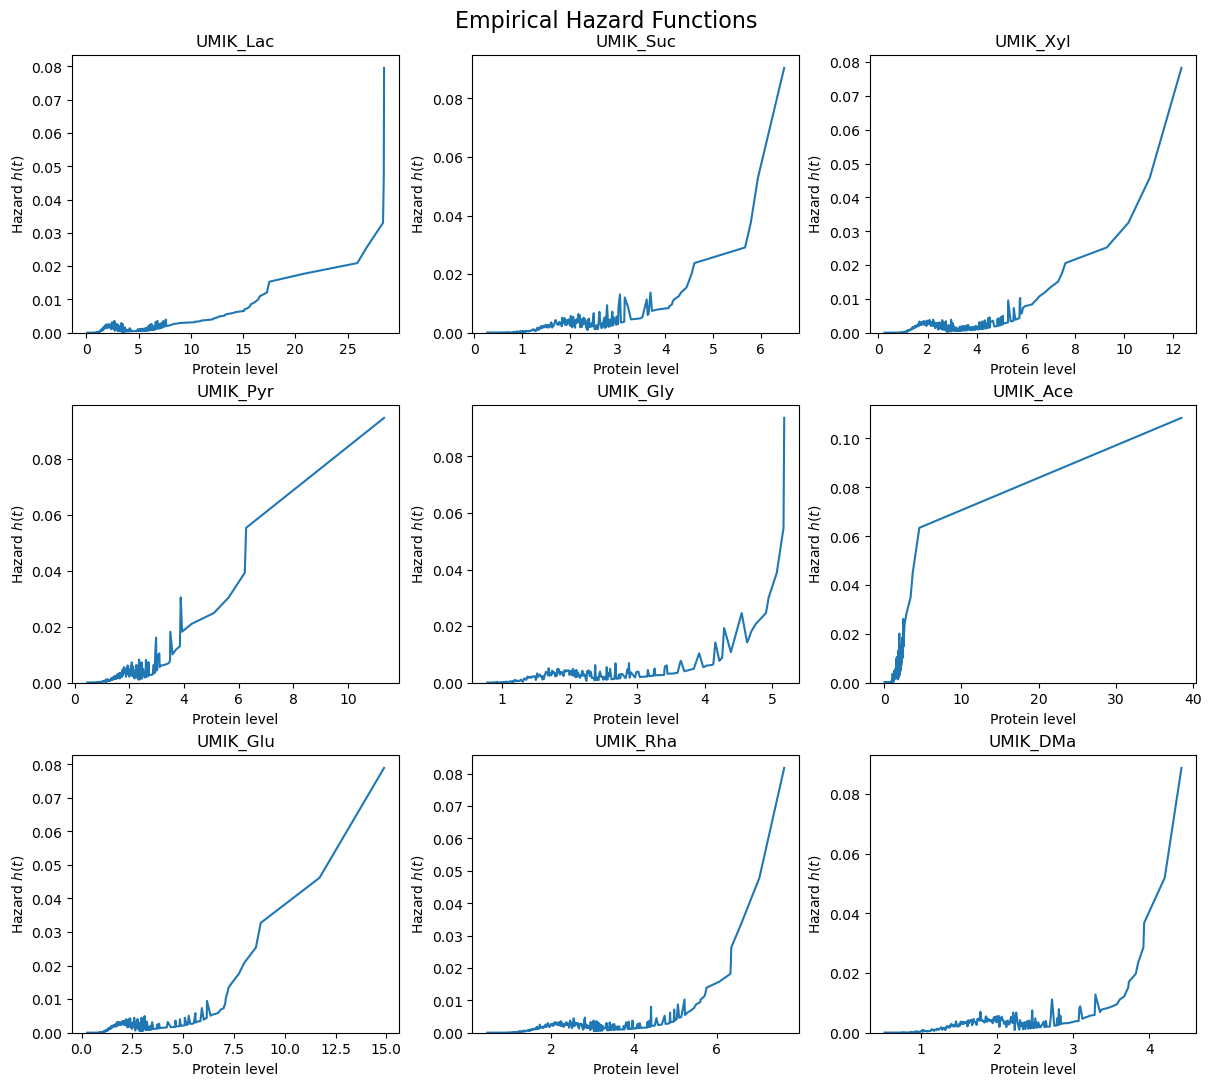

In [5]:
hazards = []                         
for name, df in dfs.items():         
    grid, h, survival = hazard_function_empirical_protein(df)
    mask = h > 0 #remove all the values where the hazard function is 0, is this the right thing to do?
    hazards.append((name, grid[:-1][mask], h[mask]))

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               

for ax, (name, grid, h) in zip(axes, hazards):

    """#remove extreme values
    if name == "UMIK_Ace":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]
    elif name == "UMIK_Pyr":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]"""

    ax.plot(grid, h, lw=1.5)
    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Hazard $h(t)$")
    ax.set_ylim(bottom=0)

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Hazard Functions", fontsize=16, y=1.02)
plt.show()

In [6]:
def logistic_survival(t, a, b):
    return 1 / (1 + np.exp(a * (t - b)))

def generalized_logistic_survival(t, tau, k, alpha):
    return 1 / (1 + (t / tau)**k)**alpha

def generalized_logistic_hazard(t, tau, k, alpha):
    t = np.asarray(t)
    term = (t / tau)
    numerator = alpha * k / tau * term**(k - 1)
    denominator = 1 + term**k
    return numerator / denominator

# Survival and Hazard funciton as a funcion of protein level

$S(p) = \frac{1}{\left(1 + \left( \frac{p}{\tau} \right)^k \right)^{a}}$

$h(p) = \frac{a k}{\tau^k} \cdot \frac{\left( \frac{p}{\tau} \right)^{k-1}}{1 + \left( \frac{p}{\tau} \right)^k}$

$f(p) = \frac{a \cdot k \cdot p^{k-1}}{\tau^k \left(1 + \left( \frac{p}{\tau} \right)^k \right)^{a + 1}}$

$p$: independent variable (protein level)

$\tau$: inflection point (location)

$k$: shape/steepness

$a$: scale or tail weight parameter

# Survival and Hazard funciton as a funcion of time

$p(t) = c m_D \left(e^{\alpha t} - 1\right)$ : Protein growth as a function of time $t$


$S(t) = \frac{1}{\left(1 + \left( \frac{c m_D (e^{\alpha t} - 1)}{\tau} \right)^k \right)^{\alpha}}$

$h(t) = \left[ \frac{\alpha k}{\tau} \cdot \frac{\left( \frac{p(t)}{\tau} \right)^{k-1}}{1 + \left( \frac{p(t)}{\tau} \right)^k} \right] \cdot c m_D \alpha e^{\alpha t}$

/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_20551/2431327484.py:5: RuntimeWarning: invalid value encountered in power
  return 1 / (1 + (t / tau)**k)**alpha


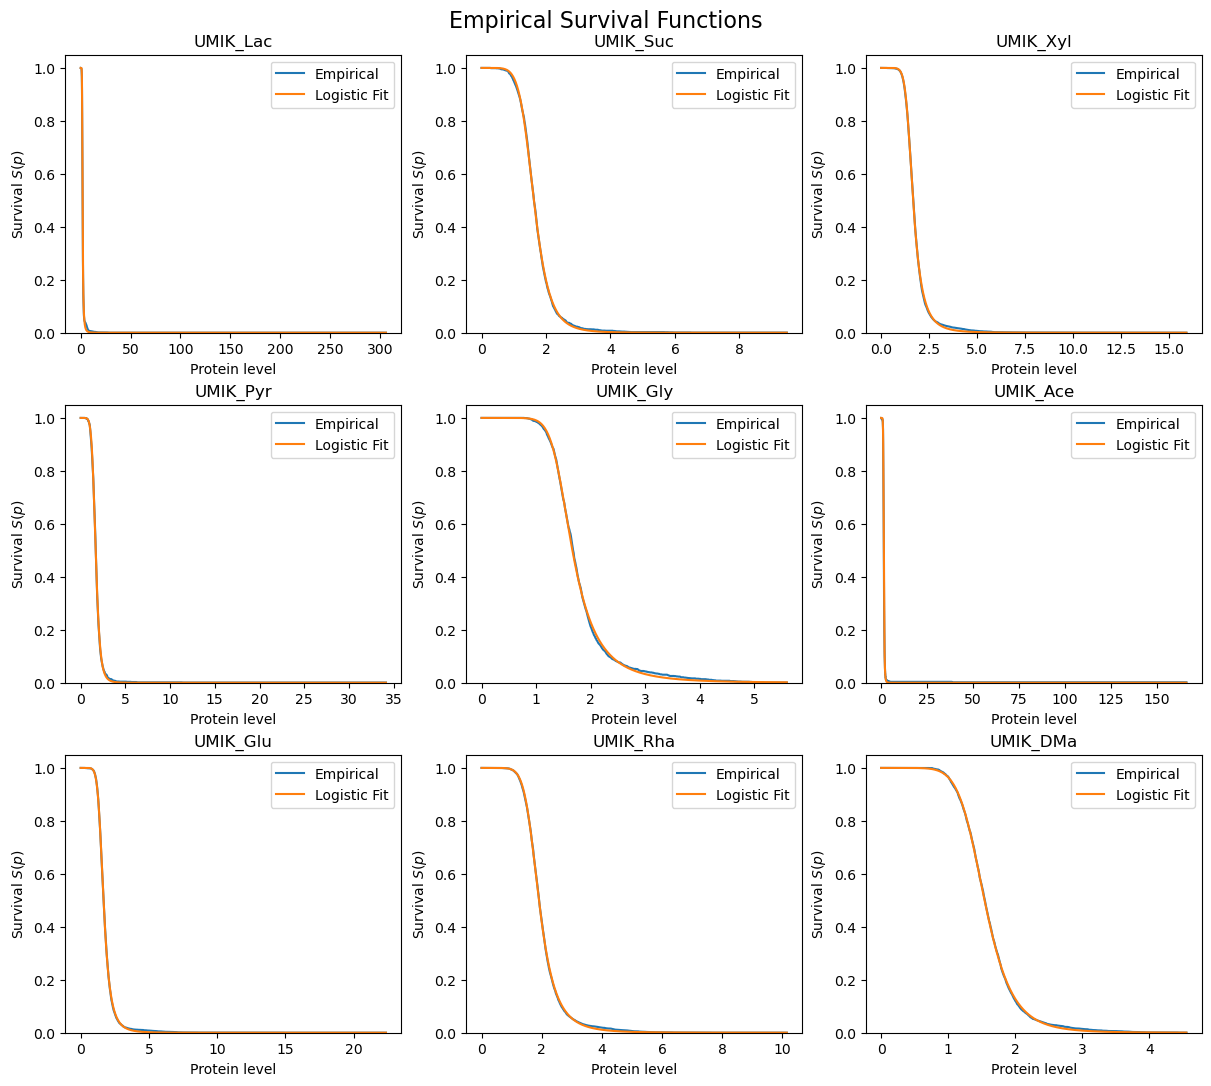

In [7]:
hazards = []                         

for name, df in dfs.items():         
    grid, h, survival = hazard_function_empirical_protein(df)
    hazards.append((name, grid[:-1], h, survival))

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               
fittingParams = []

for ax, (name, grid, h, survival) in zip(axes, hazards):

    popt, _ = curve_fit(generalized_logistic_survival, grid, survival, p0=[1, 1, 1])
    grid_fit = np.linspace(min(grid), max(grid), len(grid))
    survival_fit = generalized_logistic_survival(grid_fit, *popt)
    fittingParams.append(popt)
    
    ax.plot(grid, survival, lw=1.5, label='Empirical')
    ax.plot(grid_fit, survival_fit, label='Logistic Fit')

    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Survival $S(p)$")
    ax.set_ylim(bottom=0)
    ax.legend()

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Survival Functions", fontsize=16, y=1.02)
plt.show()

fittingParams = pd.DataFrame(fittingParams)
fittingParams.columns = ["T", "k", "a"]

In [13]:
fittingParams

,T,k,a
0,1.597620,9.063562,0.402818
1,1.627688,6.695966,1.008939
2,1.503213,9.204902,0.543990
3,1.696184,6.879143,1.061840
4,1.486226,9.994281,0.487794
5,1.433339,8.987700,0.845285
6,1.545813,8.273218,0.643941
7,1.777104,8.197598,0.675169
8,1.520874,7.688450,0.926811


In [14]:
fittingParams['T'][8]

1.5208737752313588

Text(0.5, 1.0, 'Fitting parameters')

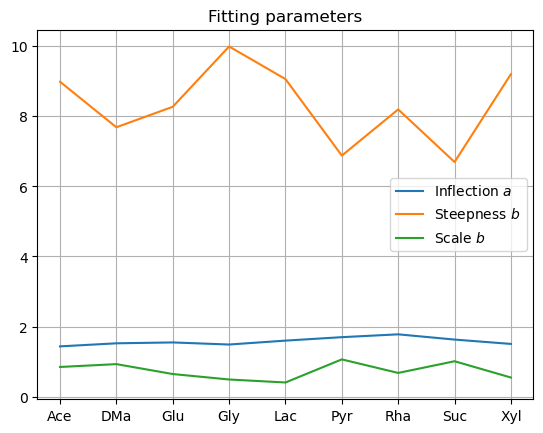

In [19]:
sugars = ["Ace", "DMa", "Glu", "Gly", "Lac", "Pyr", "Rha", "Suc", "Xyl"]

plt.plot(fittingParams["T"], label ='Inflection $a$')
plt.plot(fittingParams["k"], label ='Steepness $b$')
plt.plot(fittingParams["a"], label ='Scale $b$')

plt.legend()
plt.grid()
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8], labels = sugars)
plt.title("Fitting parameters")

Text(0.5, 1.0, 'Scatter Plot of Fitting Parameters T - k')

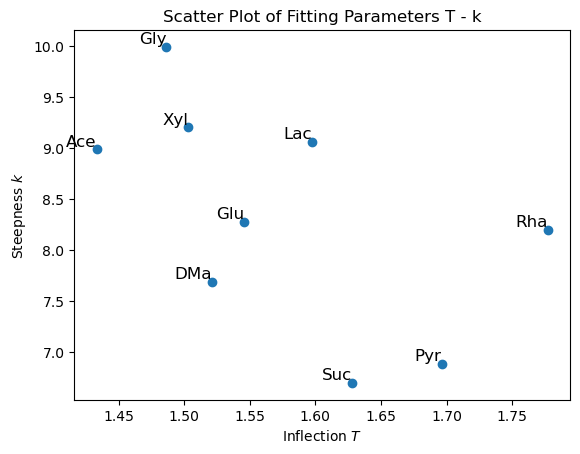

In [21]:
T = fittingParams["T"]
k = fittingParams["k"]
a = fittingParams["a"]

plt.scatter(T,k)
for i, label in enumerate(sugars):
    plt.text(T[i], k[i], label, fontsize=12, ha='right', va='bottom')
plt.xlabel('Inflection $T$')
plt.ylabel('Steepness $k$')
plt.title('Scatter Plot of Fitting Parameters T - k')

# Hazard function from survial fit (DMa)

In [24]:
grid = hazards[1][1]
h = hazards[1][2]
survival = hazards[1][3]

In [26]:
popt, _ = curve_fit(generalized_logistic_survival, grid, survival, p0=[1, 1, 1])
grid_fit = np.linspace(min(grid), max(grid), len(grid))
survival_fit = generalized_logistic_survival(grid_fit, *popt)

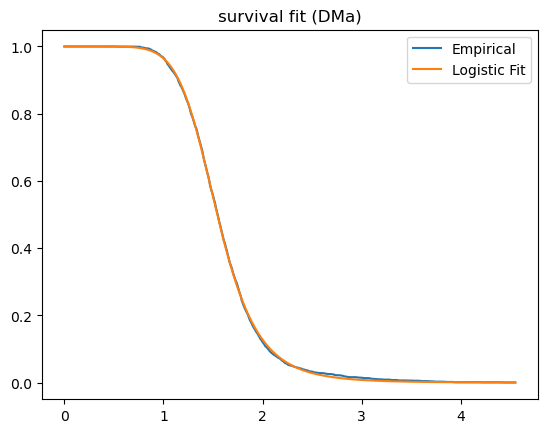

In [28]:
plt.plot(grid, survival, lw=1.5, label='Empirical')
plt.plot(grid_fit, survival_fit, label='Logistic Fit')
plt.title("survival fit (DMa)")
plt.legend()

In [30]:
hazard = np.empty(len(grid)-1, dtype=float)
for p in range(len(grid) - 1):
    if survival_fit[p] > 0 and survival_fit[p+1] > 0:
        hazard[p] = - (np.log(survival_fit[p+1]) - np.log(survival_fit[p])) / (grid_fit[p+1] - grid_fit[p])
    else:
        hazard[p] = 0

Text(0.5, 1.0, 'hazard from survival fit (DMa)')

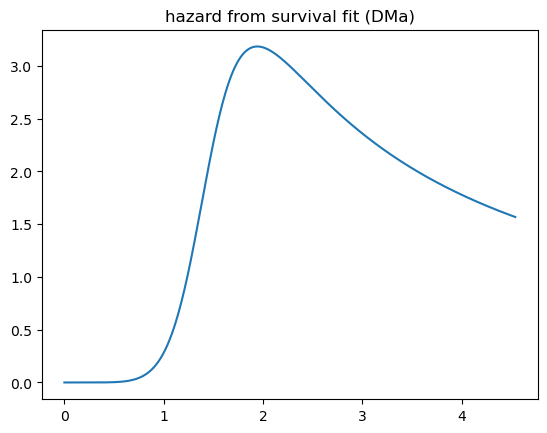

In [32]:
plt.plot(grid_fit[:-1],hazard)
plt.title("hazard from survival fit (DMa)")

In [36]:
u = grid_fit

log_l_vals=np.empty(u.shape[0])

for i,u_i in enumerate(u):
    params_val = [u_i ,v_true,omega2_true,alpha2_true,beta2_true,alpha1_true,scale1_true]
    log_l_vals[i]=model2.log_likelihood(params_val,initial_mass,lineagest,timest,alphast,fst)


plt.plot(u,log_l_vals ,lw=2, ls='dashed', color='blue',  label='')
plt.title("Likelihood with u variable")
plt.ylabel(" log(likelihood) value")
plt.xlabel(" u value")
plt.show()
print("True values:", initial_values)

NameError: name 'v_true' is not defined

In [8]:
def protein_levels_at_division_pdf(p, alpha, k, tau):
    # Compute the probability density function (PDF) of the protein levels
    return (alpha * k/(tau**k)) * (p**(k-1)) / ((1 + (p/tau)**k)**(alpha + 1))


Acceptance rate: 0.534


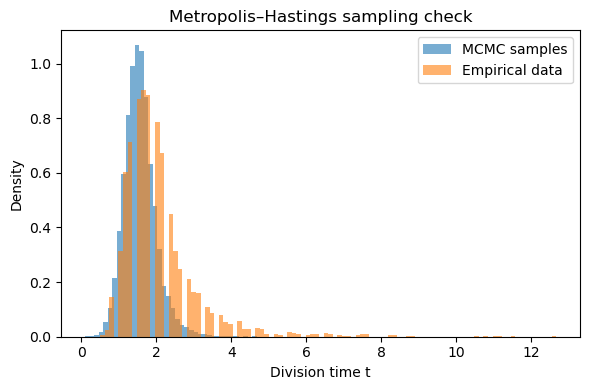

In [10]:
# --- Parameters that we got from the fit ------------------------------------
alpha = fittingParams['a'][1]   # shape/“heaviness” of the tail
k     = fittingParams['k'][1]   # shape/“peakedness”
tau   = fittingParams['T'][1]   # scale (same units as t)


# --- Metropolis–Hastings sampler -----------------------------------
n_samples = 50_000
burn_in   = 5_000        # discarded warm‑up iterations
step_size = 0.45         # std‑dev of the proposal on log‑scale

samples   = np.zeros(n_samples, dtype=float)
log_t_cur = np.log(tau)  # sensible starting guess

rng = np.random.default_rng()

accept_cnt = 0
for i in range(n_samples):
    # propose on log‑scale so t > 0 automatically
    log_t_prop = log_t_cur + rng.normal(0.0, step_size)
    t_cur, t_prop = np.exp(log_t_cur), np.exp(log_t_prop)

    # Metropolis acceptance ratio (proposal symmetric in log‑space)
    log_acc_ratio = np.log(protein_levels_at_division_pdf(t_prop, alpha, k, tau)) - \
                    np.log(protein_levels_at_division_pdf(t_cur,  alpha, k, tau))
    if np.log(rng.random()) < log_acc_ratio:
        log_t_cur = log_t_prop   # accept
        accept_cnt += 1

    samples[i] = np.exp(log_t_cur)

accept_rate = accept_cnt / n_samples
print(f"Acceptance rate: {accept_rate:.3f}")

# --- Diagnostics & visual check ------------------------------------
posterior_samples = samples[burn_in:]
empirical_time = dfs["UMIK_DMa"]["generationtime"].dropna()
empirical_time = empirical_time[empirical_time > 0]

plt.figure(figsize=(6, 4))
from scipy import stats

plt.hist(posterior_samples, bins=round(np.sqrt(empirical_time.count())), density=True, alpha=0.6, label="MCMC samples", color='C0')
plt.hist(empirical_time, bins=100, density=True, alpha=0.6, label="Empirical data", color='C1')
#plt.hist(empirical_time, bins=round(np.sqrt(empirical_time.count())), density=True, label='Empirical', color='gray', alpha=0.4)

plt.xlabel("Division time t")
plt.ylabel("Density")
plt.title("Metropolis–Hastings sampling check")
plt.legend()
plt.tight_layout()

Acceptance rate: 0.629


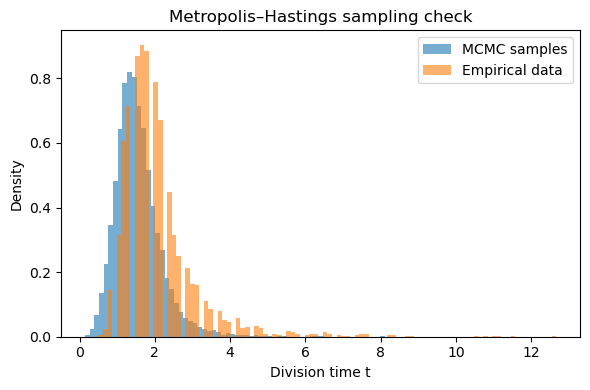

In [57]:
# --- Parameters that we played with------------------------------------
alpha = 0.80  # shape/“heaviness” of the tail
k     = 5.1   # shape/“peakedness”
tau   = 1.55  # scale (same units as t)

# --- Metropolis–Hastings sampler -----------------------------------
n_samples = 50_000
burn_in   = 5_000        # discarded warm‑up iterations
step_size = 0.45         # std‑dev of the proposal on log‑scale

samples   = np.zeros(n_samples, dtype=float)
log_t_cur = np.log(tau)  # sensible starting guess

rng = np.random.default_rng()

accept_cnt = 0
for i in range(n_samples):
    # propose on log‑scale so t > 0 automatically
    log_t_prop = log_t_cur + rng.normal(0.0, step_size)
    t_cur, t_prop = np.exp(log_t_cur), np.exp(log_t_prop)

    # Metropolis acceptance ratio (proposal symmetric in log‑space)
    log_acc_ratio = np.log(division_time_pdf(t_prop, alpha, k, tau)) - \
                    np.log(division_time_pdf(t_cur,  alpha, k, tau))
    if np.log(rng.random()) < log_acc_ratio:
        log_t_cur = log_t_prop   # accept
        accept_cnt += 1

    samples[i] = np.exp(log_t_cur)

accept_rate = accept_cnt / n_samples
print(f"Acceptance rate: {accept_rate:.3f}")

# --- Diagnostics & visual check ------------------------------------
posterior_samples = samples[burn_in:]
empirical_time = dfs["UMIK_DMa"]["generationtime"]
plt.figure(figsize=(6, 4))
plt.hist(posterior_samples, bins=100, density=True, alpha=0.6, label="MCMC samples", color='C0')
plt.hist(empirical_time, bins=100, density=True, alpha=0.6, label="Empirical data", color='C1')

plt.xlabel("Division time t")
plt.ylabel("Density")
plt.title("Metropolis–Hastings sampling check")
plt.legend()
plt.tight_layout()

In [31]:
def metropolis_hastings(unnorm_pdf, alpha, k, tau, n_samples=100000, proposal_width=1.0, burn_in=50000):
    samples = []
    p_current = np.random.rand() + 0.1  # initial value > 0
    for _ in range(n_samples + burn_in):
        p_proposal = np.random.normal(p_current, proposal_width)
        if p_proposal <= 0:
            continue  # stay in domain

        # Acceptance probability
        p_accept = min(1, unnorm_pdf(p_proposal, alpha, k, tau) / unnorm_pdf(p_current, alpha, k, tau))

        if np.random.rand() < p_accept:
            p_current = p_proposal

        samples.append(p_current)

    return np.array(samples[burn_in:])



In [30]:
100000/2


50000.0

In [24]:
print(dfs[names[1]].head())


   div_and_fold  fold_growth  division_ratio  added_length  generationtime  \
0      0.993658     0.619216        0.508323      1.945196        3.000000   
1      1.159068     0.722207        0.513954      2.569186        3.666667   
2      0.856708     0.475347        0.512369      1.589475        2.000000   
3      1.019333     0.540694        0.569015      1.780819        1.833333   
4      1.146783     0.778635        0.489762      2.648473        2.166667   

   length_birth  length_final  growth_rate  lineage_ID  generation  \
0      2.037331      3.982527     0.206405      1504.0         0.0   
1      2.046834      4.616020     0.196966      1504.0         1.0   
2      2.365108      3.954582     0.237674      1504.0         2.0   
3      2.250216      4.031035     0.294924      1504.0         3.0   
4      1.974249      4.622723     0.359370      1504.0         4.0   

   start_time   end_time  protein_level  
0    0.000000   3.000000       1.746952  
1    3.166667   6.833333  

### Sampling with determistic parameters

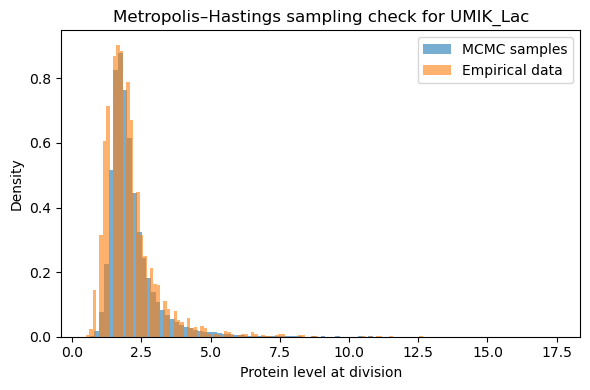

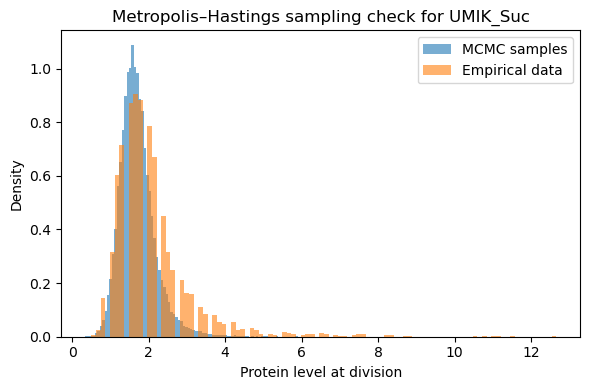

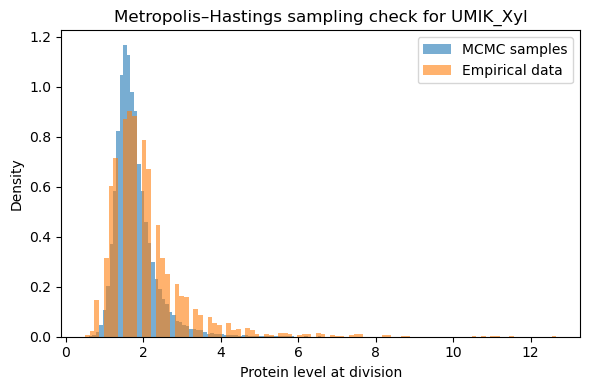

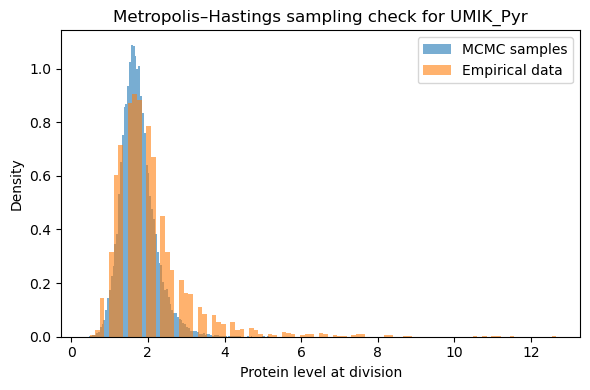

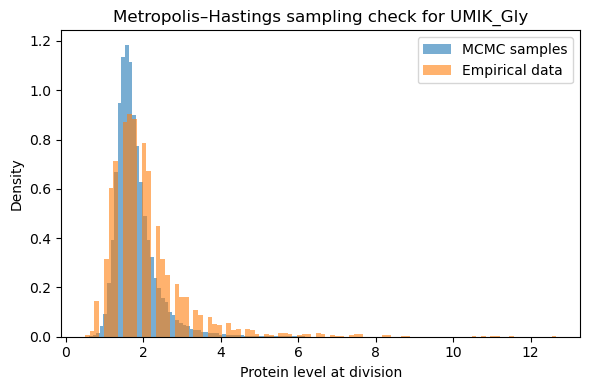

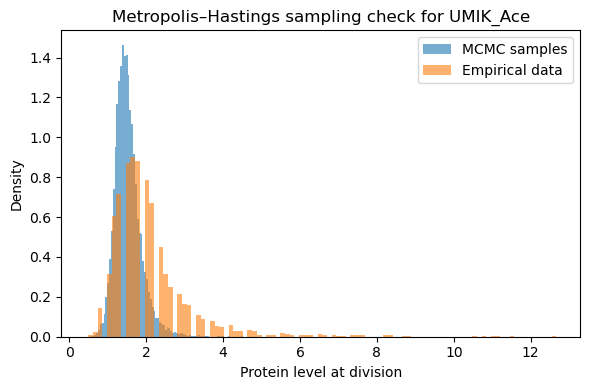

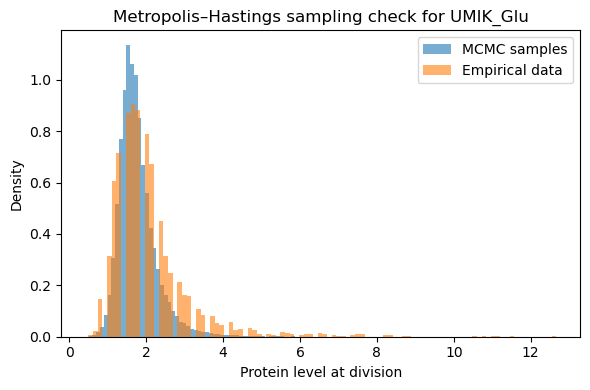

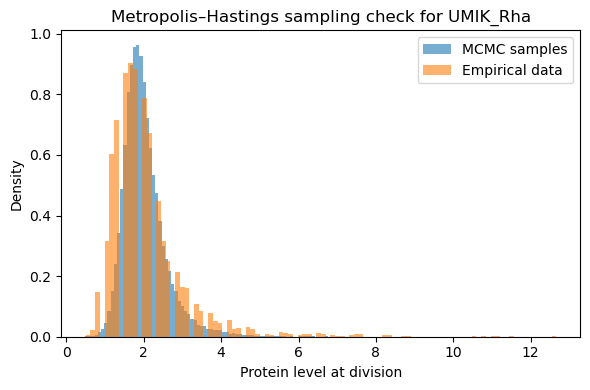

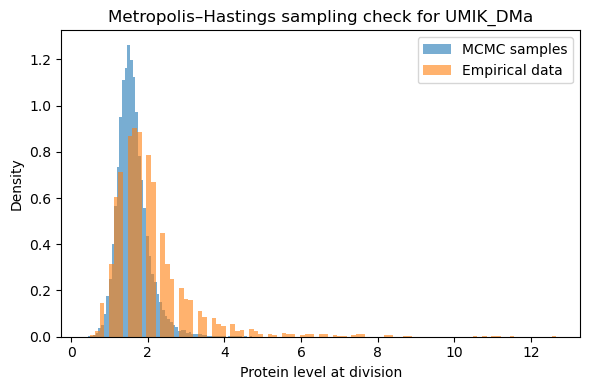

In [32]:
for i in range(len(fittingParams['a'])):
    alpha, k, tau = fittingParams['a'][i], fittingParams['k'][i] , fittingParams['T'][i]
    samples = metropolis_hastings(protein_levels_at_division_pdf, alpha, k, tau)

    posterior_samples = samples[burn_in:]
    empirical_protein_level = dfs[names[i]]["protein_level"]
    plt.figure(figsize=(6, 4))
    plt.hist(posterior_samples, bins=100, density=True, alpha=0.6, label="MCMC samples", color='C0')
    plt.hist(empirical_time, bins=100, density=True, alpha=0.6, label="Empirical data", color='C1')

    plt.xlabel("Protein level at division")
    plt.ylabel("Density")
    plt.title(f"Metropolis–Hastings sampling check for {names[i]}")
    plt.legend()
    plt.tight_layout()

In [ ]:
def gamma_pdf(x, alpha, beta):
    """Gamma probability density function."""
    return (beta**alpha / math.gamma(alpha)) * (x**(alpha - 1)) * np.exp(-beta * x)

def beta_pdf(x, a, b):
    """Beta probability density function."""
    if x < 0 or x > 1:
        return 0
    return (x**(a - 1) * (1 - x)**(b - 1)) / stats.beta(a, b).pdf(1)

def likelihood(protein_level):
    # Calculate the likelihood of the protein level given the parameters
    return protein_levels_at_division_pdf(protein_level, alpha, k, tau) * beta_pdf(protein_level, np.mean(protein_level), np.std(protein_level)) * gamma_pdf(protein_level, np.mean(protein_level), np.std(protein_level))

def total_likelihood(protein_levels, alpha, k, tau):
    # Calculate the total likelihood for all protein levels
    return np.prod([likelihood(pl, alpha, k, tau) for pl in protein_levels])

In [ ]:
for name in names:
    protein_levels = dfs[name]["protein_level"].dropna()
    alpha = metropolis_hastings(total_likelihood, fittingParams['a'][names.index(name)],

### Superimposing the empirical calculation with the fit